In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

import random

Using TensorFlow backend.


In [2]:
#reading the dataset
#I've split the dataset to hold data for only one person and store it in a separate text file 
#to ensure consistency with respect to time

def readData():
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/onePersonData.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data
    


In [3]:
def createGap(data):
    seed = random.randint(500,len(data)-300)
    print(seed)
    #introduce a gap of 250 values
    for i in range(seed, seed+250):
        data['GlucoseValue'][i] = 0
    
    #plt.figure(figsize=(20, 8))
    #data.plot()
    return data,seed

In [4]:
def getTrainSet(data):
    i=0
    while(data['GlucoseValue'][i]!=0):
        i+=1
        if(data['GlucoseValue'][i]==0):
            break
    train_set=data.iloc[:i]
    return train_set

In [5]:
def getGapSize(data):
    s=0
    for i in range(0,len(data)):
        if(data['GlucoseValue'][i]==0):
            s+=1
    
    return s
    

In [6]:
data = readData()    
data.head()

,GlucoseValue
Display Time,
2014-02-03 03:42:12,93
2014-02-03 03:47:12,93
2014-02-03 03:52:12,93
2014-02-03 03:57:12,95
2014-02-03 04:02:12,96


In [7]:
#data['GlucoseValue'][8]

In [8]:
data,seed = createGap(data)

1008


In [9]:
#print(data)
#print(seed)

In [10]:
gap_size = getGapSize(data)

In [11]:
#print(gap_size)

In [12]:
train = getTrainSet(data)
train.head()
#print(len(train_set))

,GlucoseValue
Display Time,
2014-02-03 03:42:12,93
2014-02-03 03:47:12,93
2014-02-03 03:52:12,93
2014-02-03 03:57:12,95
2014-02-03 04:02:12,96


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_sc = scaler.fit_transform(train)

X_train = train_sc[:-1]
y_train = train_sc[1:]

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)


X_train = X_train.as_matrix()
y_train = y_train.as_matrix()


X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# The LSTM networks creation and model compiling is similar with those of ANN’s.
# The LSTM has a visible layer with 1 input.
# A hidden layer with 7 LSTM neurons.
# An output layer that makes a single value prediction.
# The relu activation function is used for the LSTM neurons.
# The LSTM is trained for 50 epochs and a batch size of 1 is used.
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=50, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])


y_train_pred_lstm = lstm_model.predict(X_train_lmse)

predicted_values = y_train_pred_lstm
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 1/50
1007/1007 [==============================] - 3s 3ms/step - loss: 0.0032
Epoch 2/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0012
Epoch 3/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 4/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 5/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 6/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 7/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 8/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 9/50
1007/1007 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 10/50
1007/1007 [==============================] - 2s 2ms/step - loss: 9.9955e-04
Epoch 11/50
1007/1007 [==============================] - 2s 2ms/step - loss: 9.9052e-04
Epoch 12/50
1007/1007 [==============================] - 2s 2ms/step - loss: 

In [14]:
predicted_values = predicted_values[len(predicted_values)-gap_size:]
#print(predicted_values)
#len(predicted_values)

In [15]:
type(predicted_values)
predicted_values = predicted_values.tolist()
#print(predicted_values)

In [16]:
predicted_values = scaler.inverse_transform(predicted_values)

In [17]:
#print(predicted_values)

In [18]:
newdata = readData()


In [19]:
#len(newdata)

In [23]:
a = newdata['GlucoseValue'].tolist()
a = a[seed-gap_size:seed]


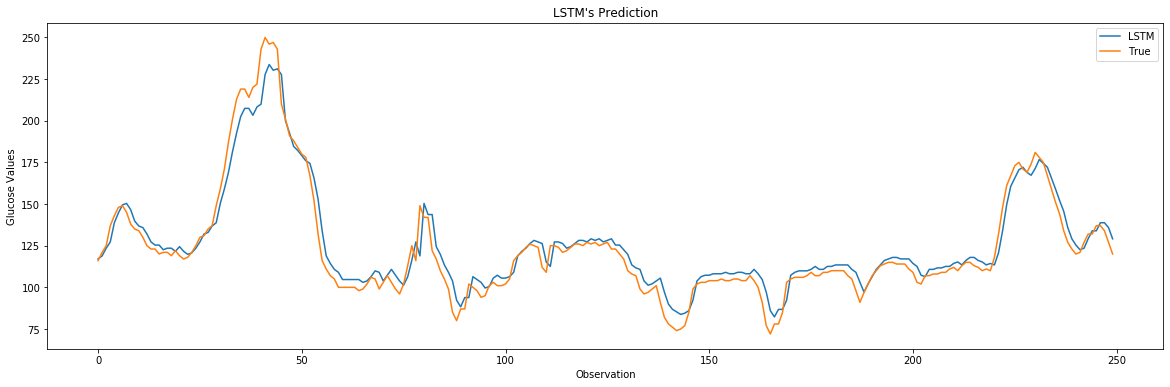

In [24]:
plt.figure(figsize=(20, 6))

plt.plot(predicted_values, label='LSTM')
plt.plot(a, label='True')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Glucose Values')
plt.legend()
plt.show();